Oversampling > 2x suggested for reliable results in Fresnel propagation.


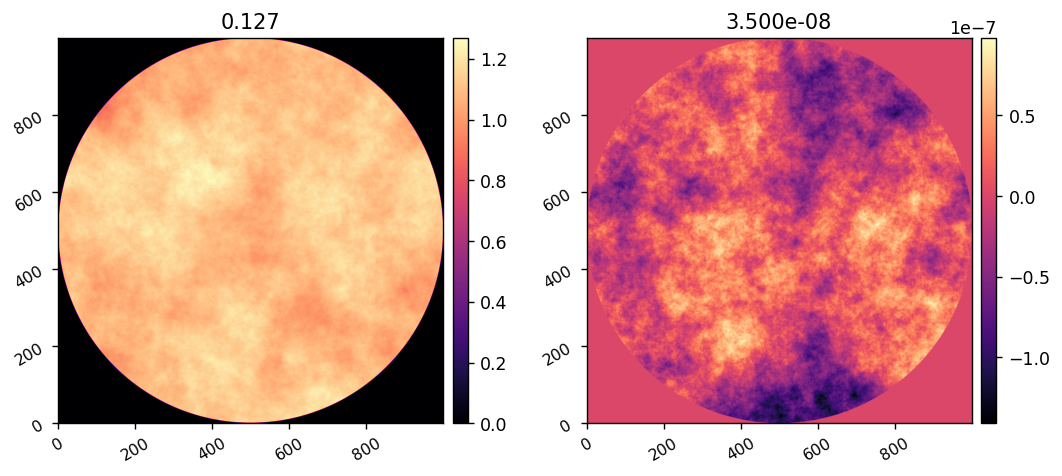

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=633*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*633e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


Oversampling > 2x suggested for reliable results in Fresnel propagation.


123 1200


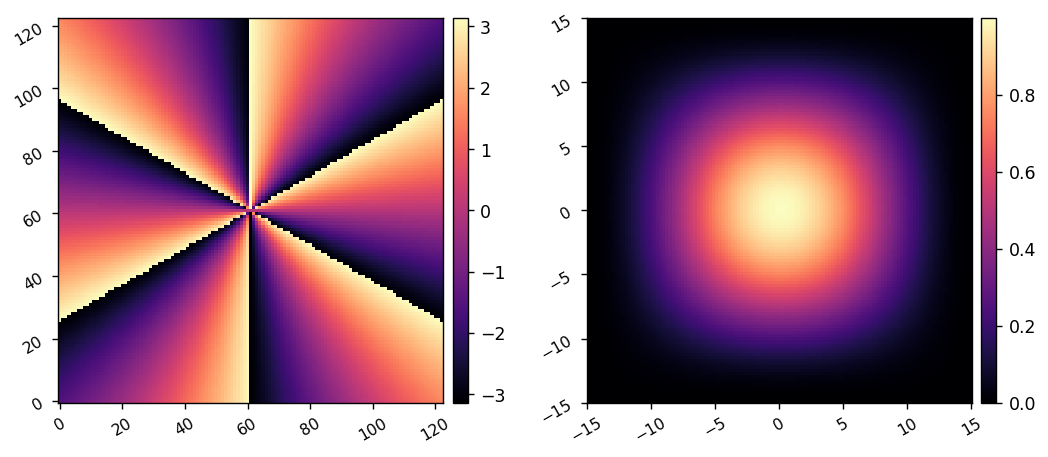

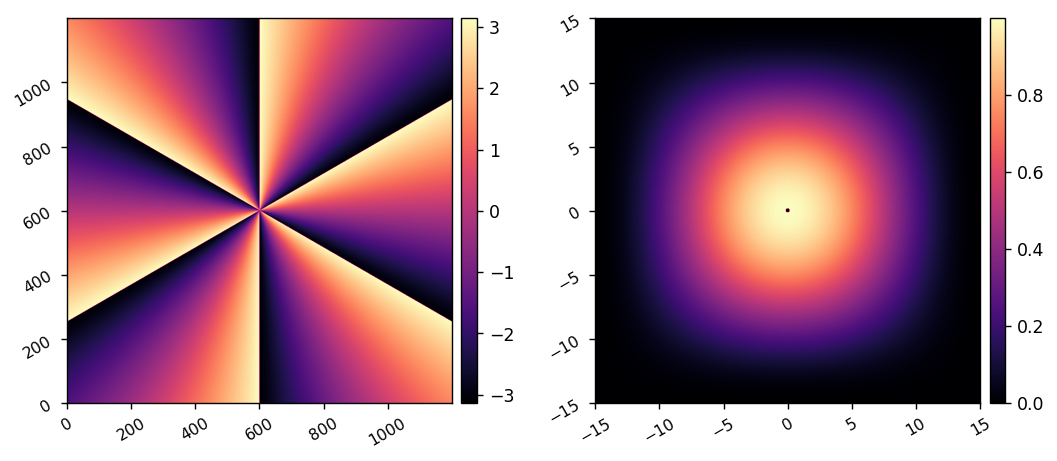

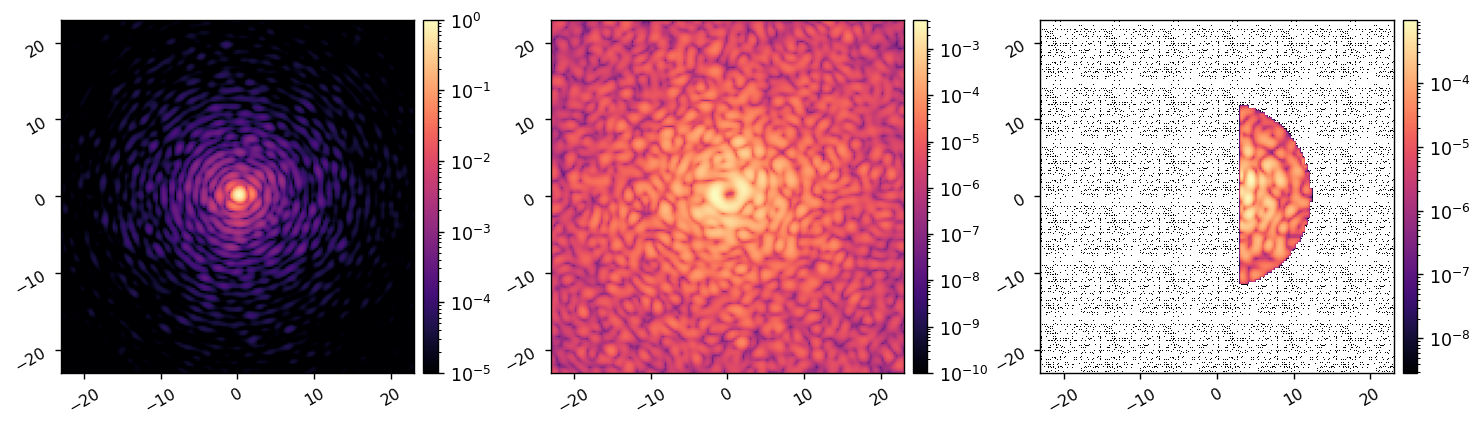

In [3]:
reload(ad_scoob)
reload(lina.utils)
m = ad_scoob.MODEL()
m.WFE = WFE

print(m.lres_win_size, m.hres_win_size,)
imshow2(xp.angle(m.vortex_lres), m.lres_window, 
        npix=m.lres_win_size,
        # npix1=M.lres_win_size, npix2=M.lres_win_size, 
        pxscl2=m.lres_sampling)
imshow2(xp.angle(m.vortex_hres), m.hres_window, 
        npix=m.hres_win_size,
        # npix1=M.hres_win_size, npix2=M.hres_win_size, 
        pxscl2=m.hres_sampling)

m.npsf = 150
# m.det_rotation = 178

control_mask = lina.utils.create_annular_control_mask(m.npsf, m.psf_pixelscale_lamD, iwa=3, owa=12, edge=3, rotation=0, centered=True)

acts = np.zeros(m.Nacts)

ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(acts)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, ref_coro_im*control_mask,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


# Test PWP

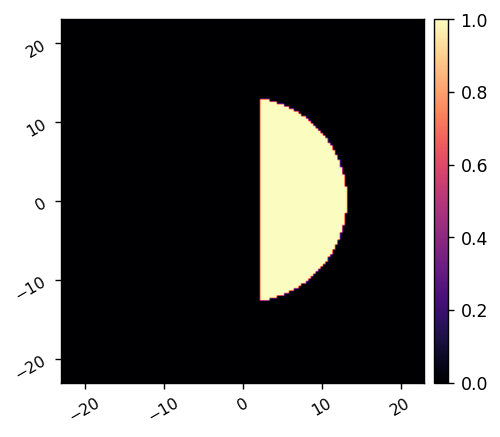

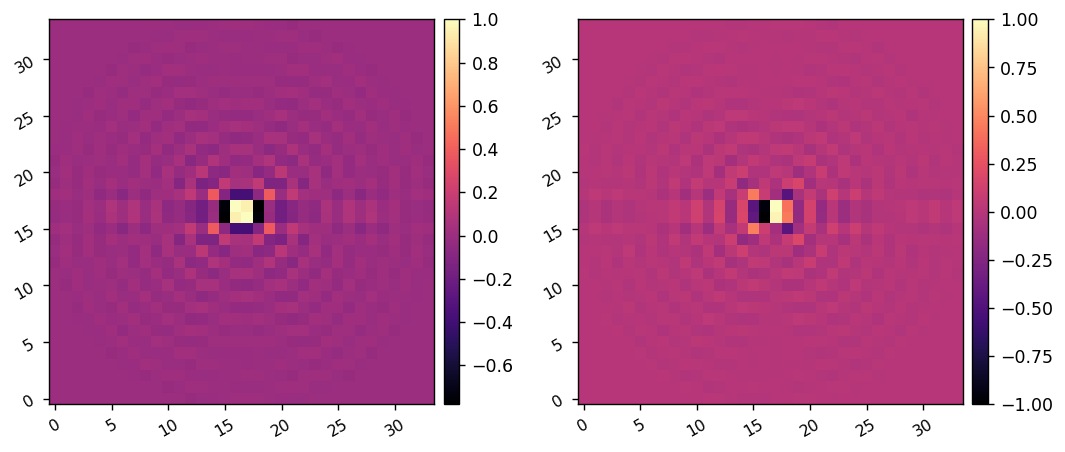

In [4]:
import lina 
reload(lina.utils)

probe_iwa = 2
probe_owa = 13
probe_mask = lina.utils.create_annular_control_mask(m.npsf, m.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=2)
imshow1(probe_mask, pxscl=m.psf_pixelscale_lamD)

# probe_mask = lina.utils.create_annular_control_mask(m.npsf, m.psf_pixelscale_lamD, 
#                                                     iwa=3, owa=12, edge=3, rotation=m.det_rotation-180, centered=True)
# imshow1(probe_mask)
probe_modes = lina.utils.create_fourier_probes(m, 
                                             #   control_mask, 
                                               probe_mask,
                                               fourier_sampling=0.25, 
                                            #    shift=[(0,8), (0,-8)], 
                                            #    shift=[(-8,0), (8,0)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
imshow2(probe_modes[0], probe_modes[1])

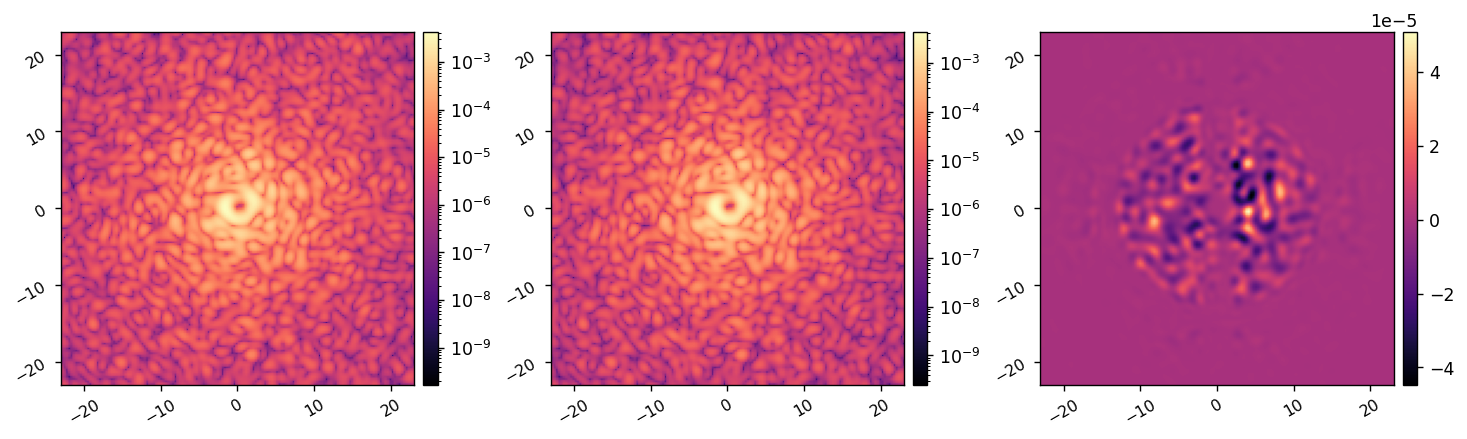

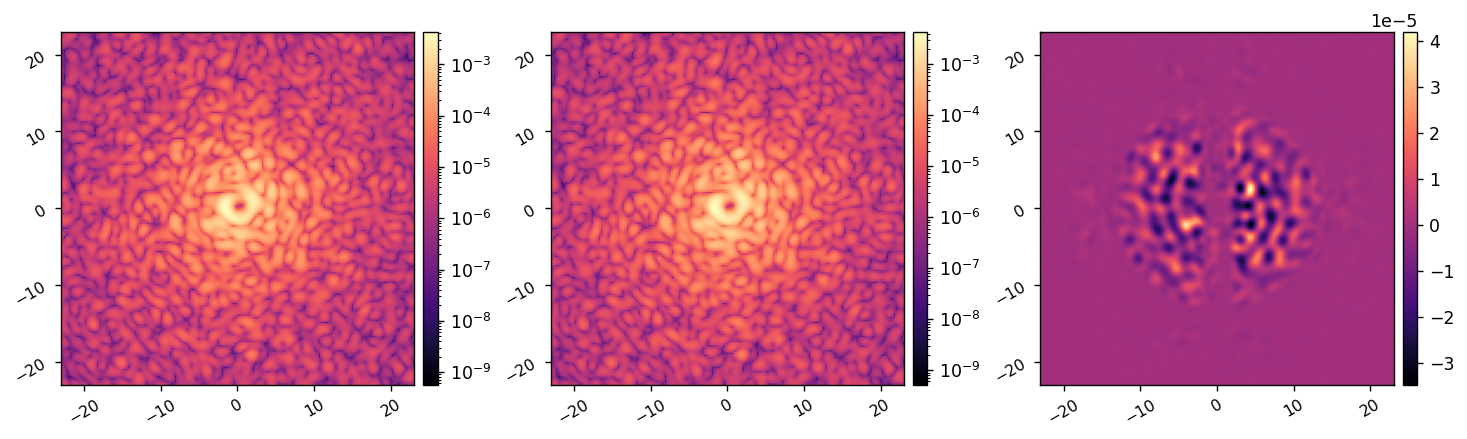

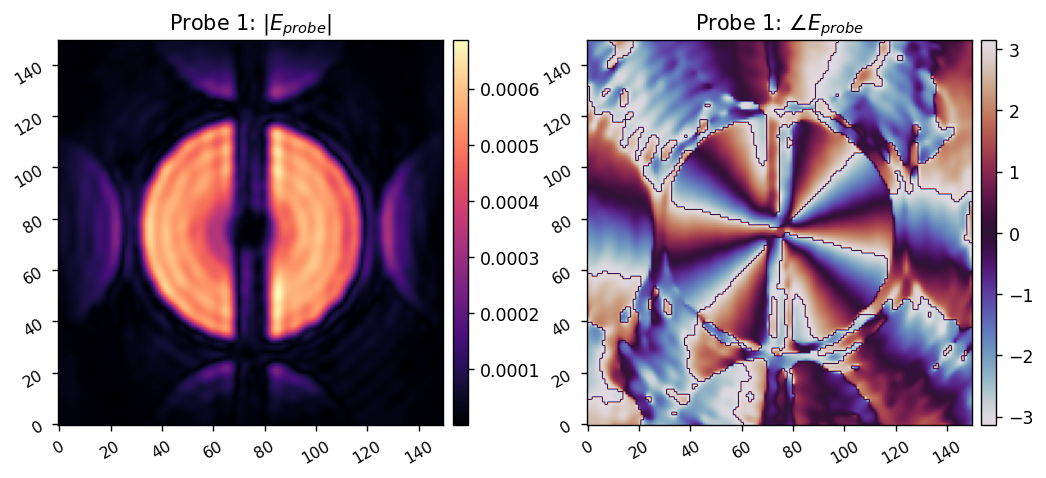

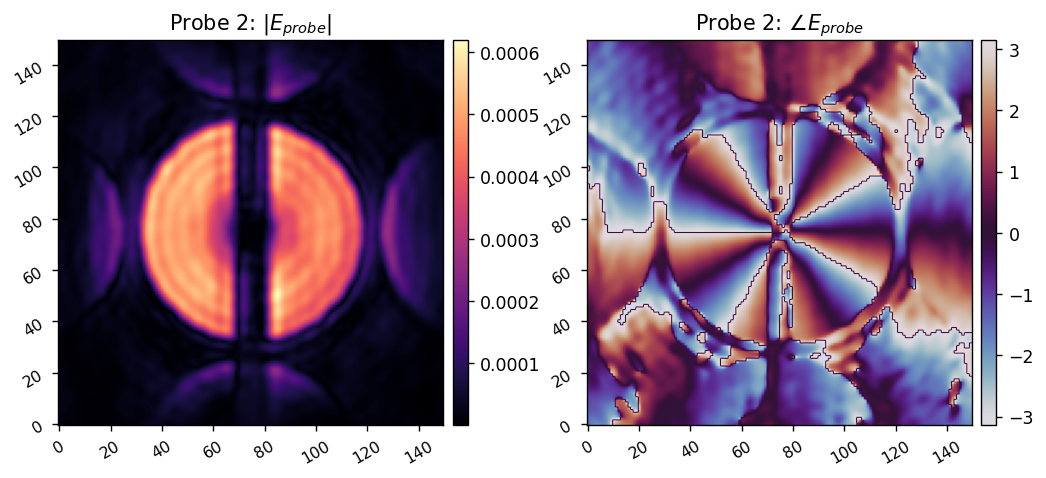

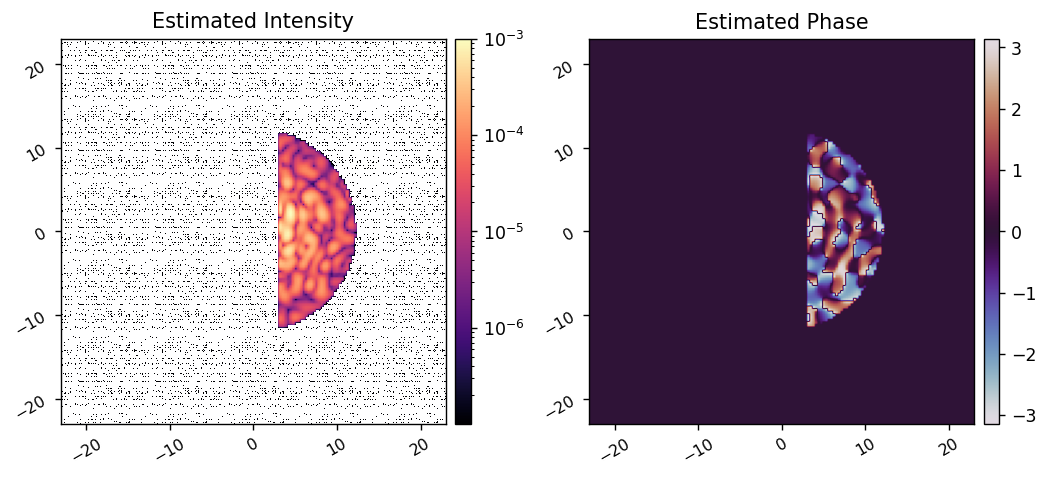

In [5]:
reload(adefc)

acts = xp.zeros(m.Nacts)
# acts = xp.array(fits.getdata('data/ad_test_acts.fits'))
probe_amp = 5e-9

E_est = adefc.sim_pwp(m, acts, control_mask,
                        xp.array(probe_modes), probe_amp, 
                        reg_cond=1e-1, 
                        plot=True,
                        plot_est=True)
I_est = xp.abs(E_est)**2
P_est = xp.angle(E_est)


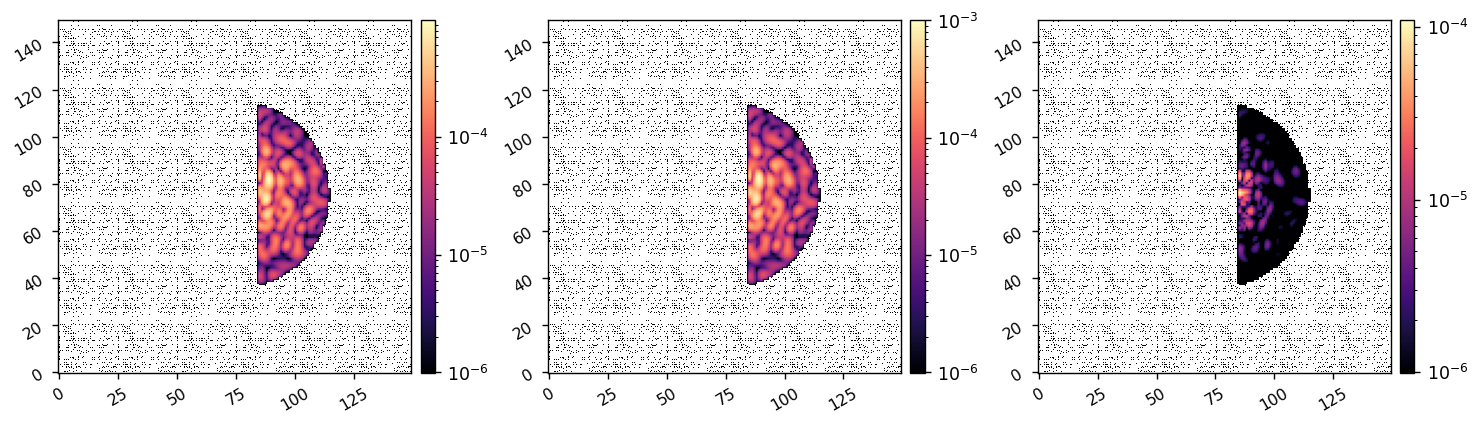

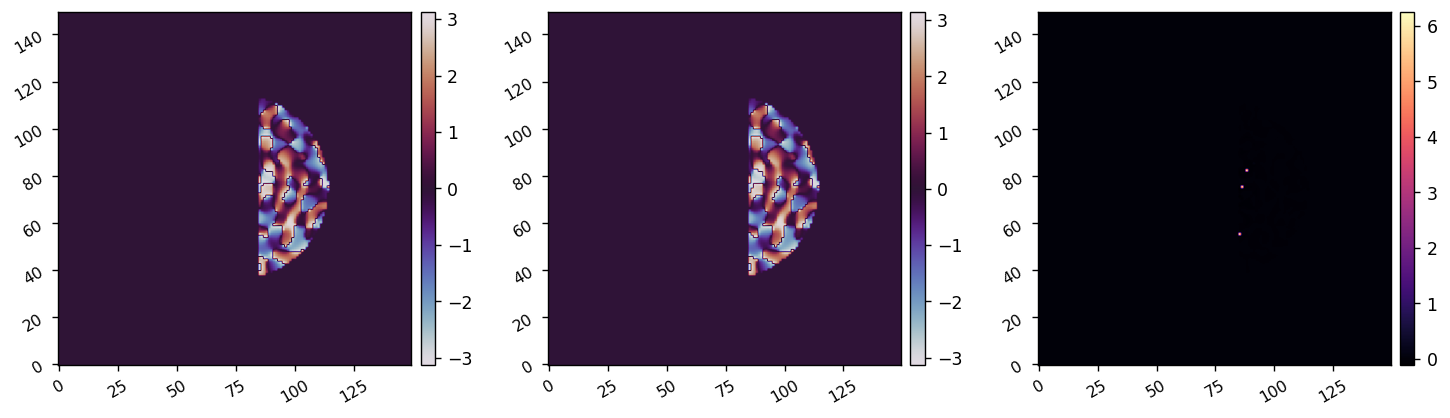

In [6]:
E = m.forward(acts)

I = xp.abs(E)**2 * control_mask
I_diff = I - I_est
vmin = xp.max(I)/1e3
imshow3(I, I_est, xp.abs(I_diff), lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

P = xp.angle(E)*control_mask
P_diff = P - P_est
imshow3(P, P_est, P_diff, cmap1='twilight', cmap2='twilight')

(1000, 1000)
0.11634369320464857 0.0 0.11634369320464857 1.0


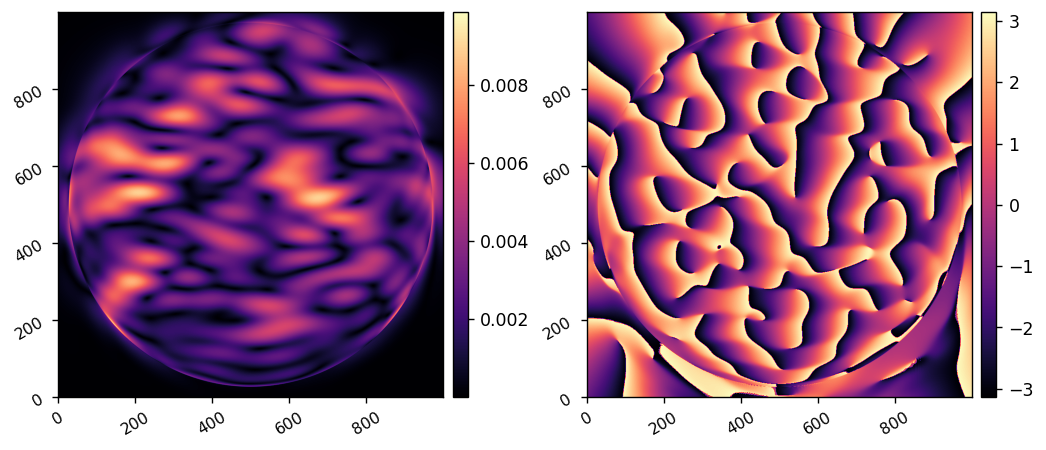

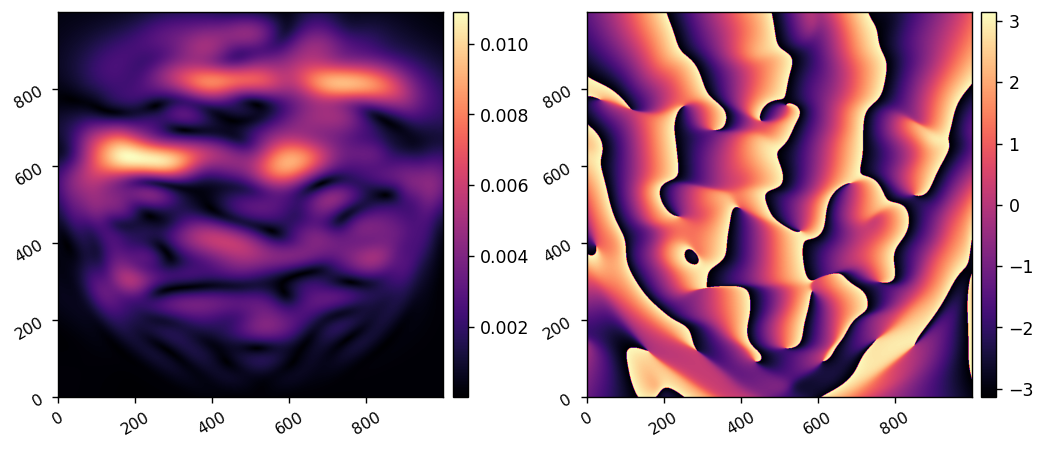

0.0


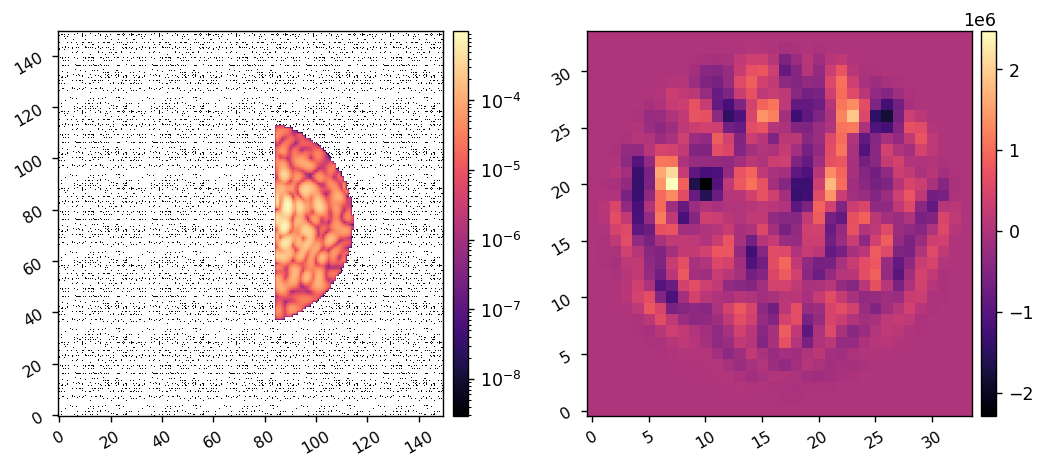

In [11]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * control_mask
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, control_mask, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
print(dm_grad[25,21])
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [38]:

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, control_mask, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


0.0883459637756196 0.0 0.0883459637756196 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.08320D+06
0.0025496365018451805 2495701154.760925 0.0883459637756196 28249181378.58609
0.004568228006520716 26.172103683511853 0.0883459637756196 296.2973156080077


 This problem is unconstrained.


0.07319732180213212 1.6091100733248551 0.0883459637756196 19.04226659861563
0.4934651862616938 0.1555720912698487 0.0883459637756196 7.3465413675259965
2.279664025430893 0.012872597348100158 0.0883459637756196 25.949534362447615
0.9289510738562332 0.000608087645994851 0.0883459637756196 10.521806789760259
0.01694543813482576 3.250156578258863e-05 0.0883459637756196 0.19217561250142437

At iterate    1    f=  1.92176D-01    |proj g|=  8.69323D+05
0.006481537537496103 3.3671282229192473e-05 0.0883459637756196 0.07374653624553322

At iterate    2    f=  7.37465D-02    |proj g|=  2.71200D+05
0.003216526918125704 4.115452056543559e-05 0.0883459637756196 0.036874140022570515

At iterate    3    f=  3.68741D-02    |proj g|=  1.54891D+05
0.0020204752827174917 4.726646379357173e-05 0.0883459637756196 0.023405050532503083

At iterate    4    f=  2.34051D-02    |proj g|=  1.14215D+05
0.001481438523057514 5.379368306448847e-05 0.0883459637756196 0.01737750249712792

At iterate    5    f=  1.73775D

5.296520610049137e-05 2.3759427864872502e-07
0.0


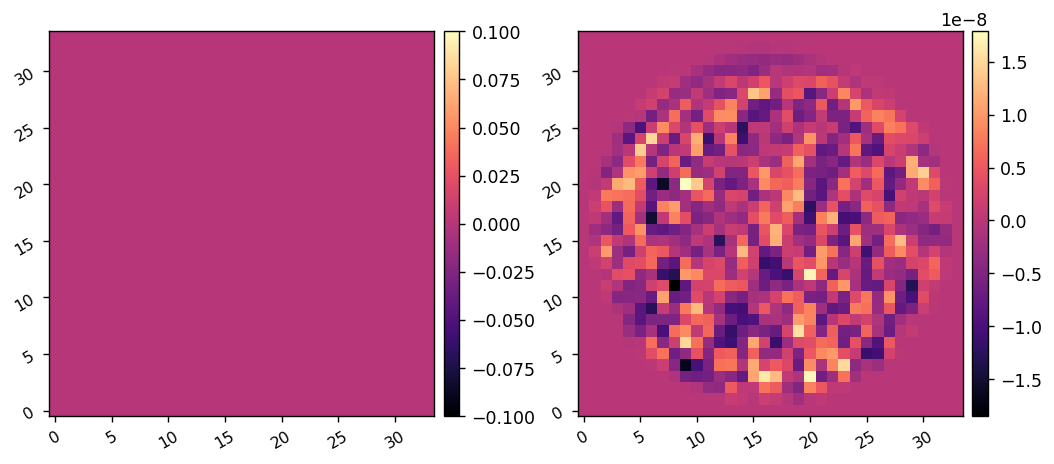

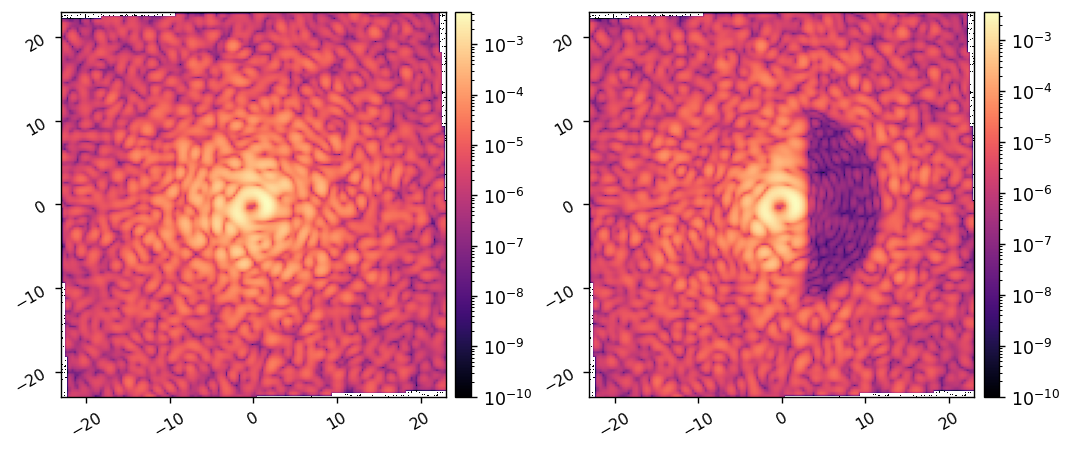

In [40]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
old_im = m.snap(acts)
new_im = m.snap(acts + res.x)
print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))

print(del_command[25,21])
imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=m.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [6]:
utils.save_fits('data/ad_test_acts.fits', res.x)

Saved data to:  data/ad_test_acts.fits


# test AD-EFC with PWP

In [47]:
all_ims = []
all_efs = []
all_commands = []


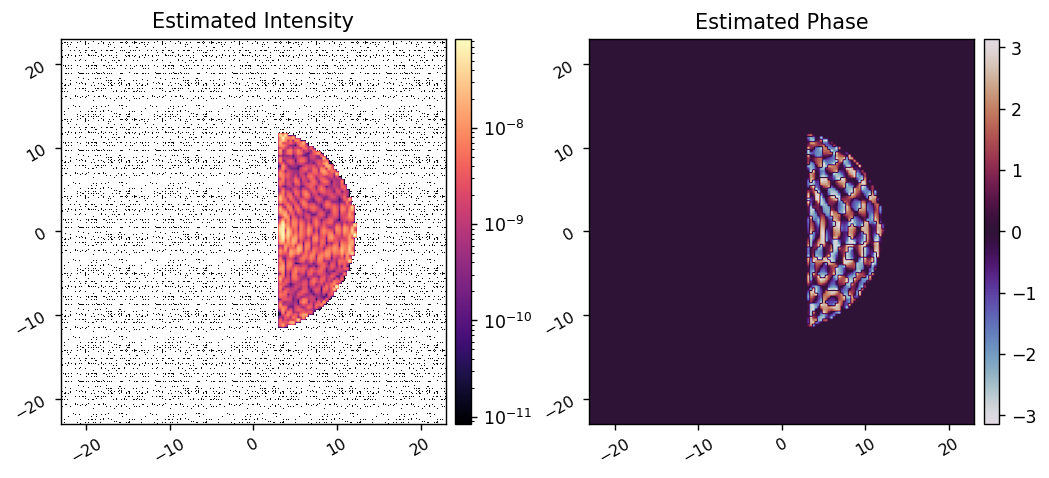

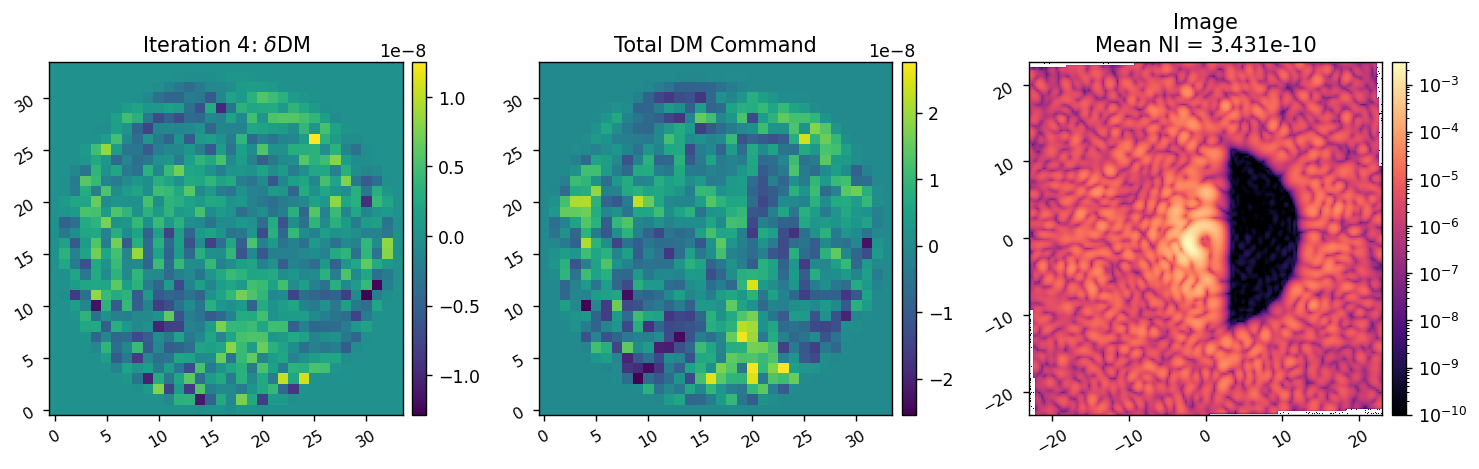

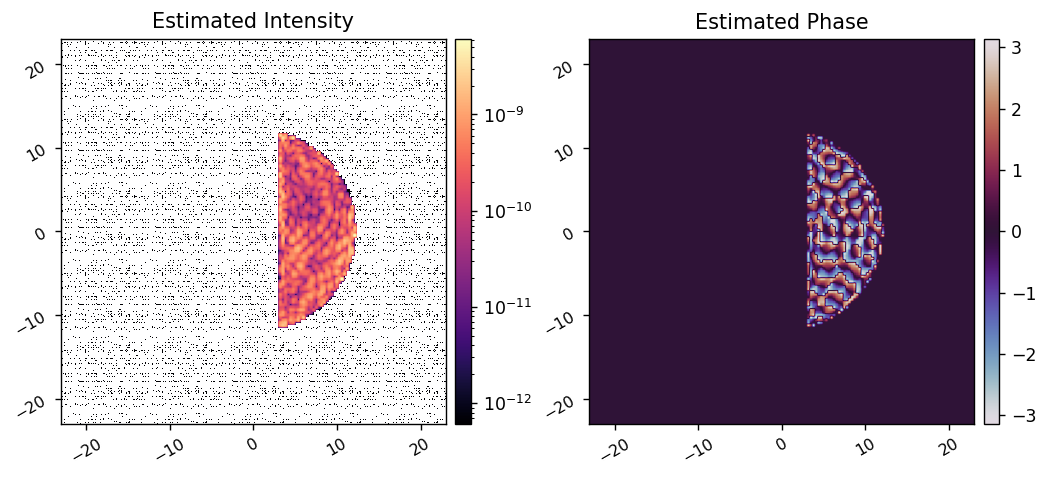

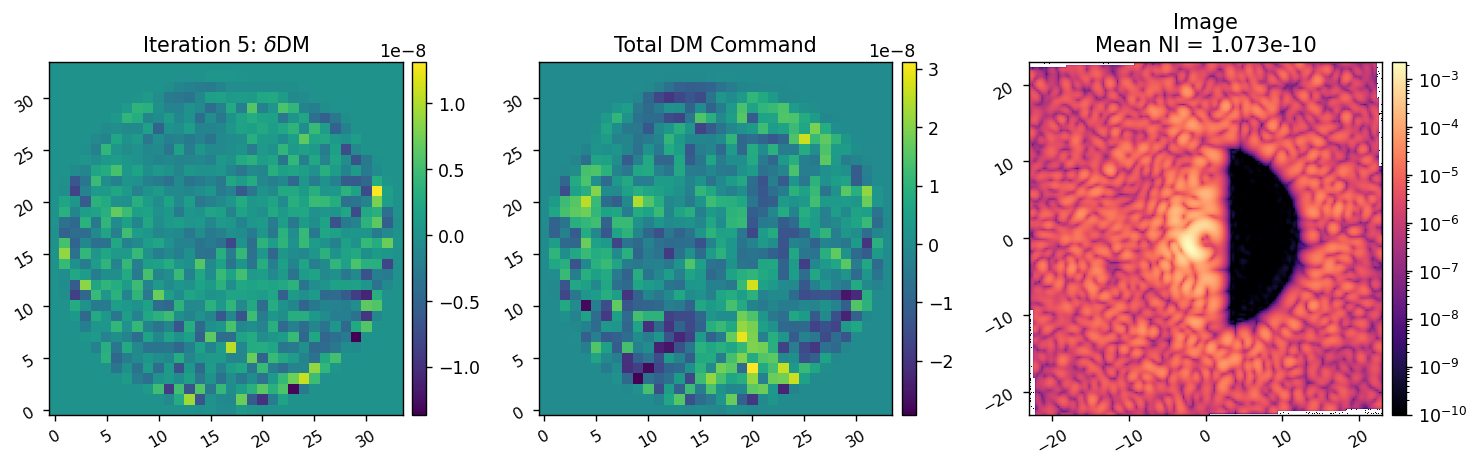

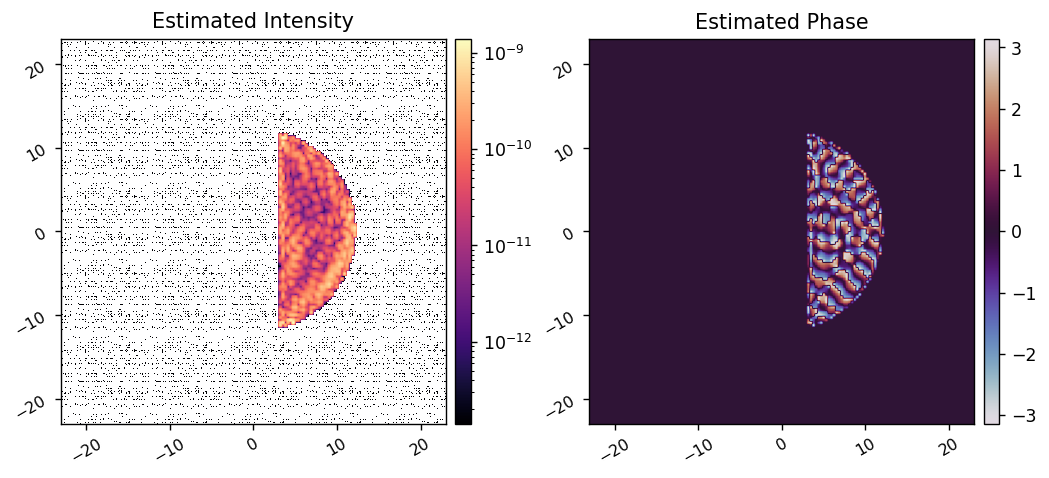

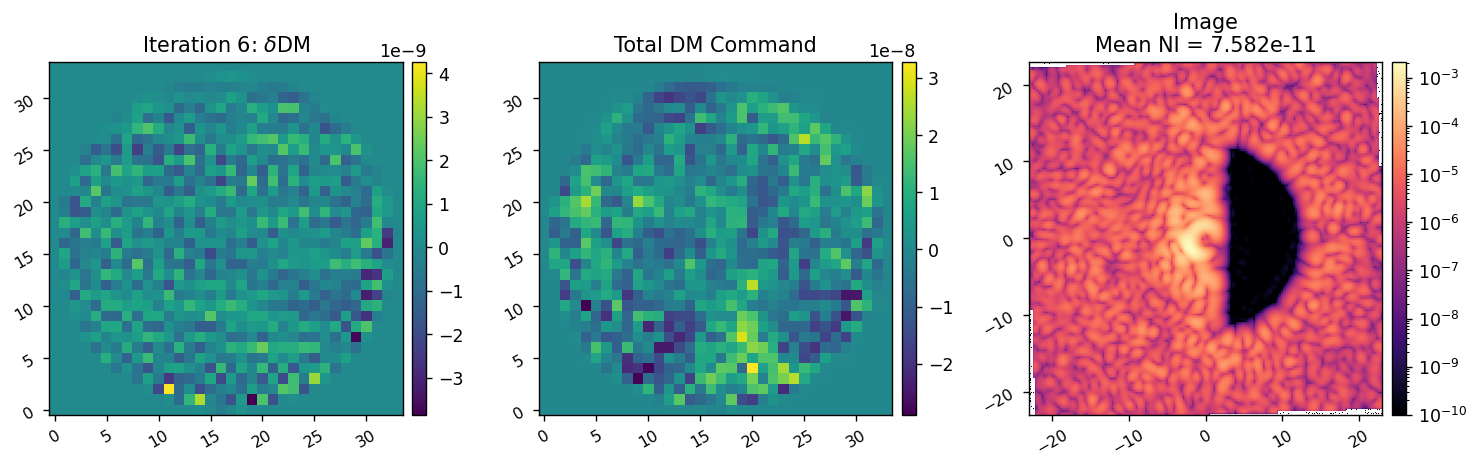

In [49]:
reload(ad_scoob)
reload(adefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

est_fun = adefc.sim_pwp
est_params = {
    # m, acts, 
    'control_mask':control_mask,
    'probes': xp.array(probe_modes), 
    'probe_amp':2.5e-9, 
    # 'reg_cond':1e-2, 
    'reg_cond':1e-3, 
    # 'reg_cond':1e-4, 
    'plot':False,
    'plot_est':True,
}

all_ims, all_efs, all_commands = adefc.sim(m, ad_scoob.val_and_grad, control_mask,
                                            est_fun, est_params, 
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )